In [12]:
import retro
import torch
import random
import pyspark
import numpy as np
import IPython.display
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import torch.nn.functional as F

spark = pyspark.sql.SparkSession.builder.getOrCreate()
sc = spark.sparkContext

spark = (pyspark.sql.SparkSession
         .builder
         .master('local[8]')
         .appName('lecture')
         .getOrCreate())

spark = (pyspark.sql.SparkSession
         .builder
         .master("local[*]")
         .config("spark.executor.memory", "70g")
         .config("spark.driver.memory", "50g")
         .config("spark.memory.offHeap.enabled", True)
         .config("spark.memory.offHeap.size","16g")   
         .appName('lecture')
         .getOrCreate())

sc = spark.sparkContext

mean  
max_  
difference  
frequency  
variance  
reverse tree eg autoenc  

In [13]:
actions_codes = {
    'Left':      [0, 0, 0, 0, 0, 0, 1, 0, 0],
    'Right':     [0, 0, 0, 0, 0, 0, 0, 1, 0],
    'Jump':      [0, 0, 0, 0, 0, 0, 0, 0, 1],
    'None':      [0, 0, 0, 0, 0, 0, 0, 0, 0],
    # 'Crouch':    [0, 0, 0, 0, 0, 1, 0, 0, 0],
    # 'Dash':      [0, 0, 1, 0, 0, 0, 0, 0, 0],
    # 'RightDash': [0, 0, 1, 0, 0, 0, 0, 1, 0],
    'LeftJump':  [0, 0, 0, 0, 0, 0, 1, 0, 1],
    'RightJump': [0, 0, 0, 0, 0, 0, 0, 1, 1]
}

codes_actions = {tuple(code): action for action, code in actions_codes.items()}

# actions = list(actions.values())
actions = list(actions_codes.keys())
actions

['Left', 'Right', 'Jump', 'None', 'LeftJump', 'RightJump']

---
### enchiridion

In [14]:
import uuid

str(uuid.uuid4())

class Environment2:
    def __init__(self):
        self.environment = retro.make(game='SuperMarioBros-Nes')
        # self.environment = retro.make(game='Airstriker-Genesis')
        
        self.blocks_seen = []
        self.blocks_seen_urls = []
        
        self.frames_all = []
        self.actions_all = []

        self.encodings = set()
        self.encodings_frame = set()
        
        asymmetric = torch.linspace(0.5, 1.5, 16*16*3)**3
        asymmetric = asymmetric.numpy()
        
        aa = torch.tensor(asymmetric).reshape(16, 16, 3).unsqueeze(0).permute(0, 3, 1, 2)
        filter_ = torch.tensor(aa, dtype=torch.float)
        self.filter_ = filter_ / 16 / 16 / 3 / 255

        self.frame = self.environment.reset()
        self.frames_all.append(self.frame)


    def step(self, action, commitment_interval):
        for _ in range(commitment_interval):
            self.frame, reward, is_done, information = self.environment.step(action)
        
        # self.blocks_identify(self.frame)
        self.frames_all.append(self.frame)
        self.actions_all.append(action)

        return self.frame, reward, is_done, information

    def close(self):
        self.environment.render(close=True)
        self.environment.close()

    __del__ = close

    
    def blocks_identify_all(self):
        t = torch.tensor(np.stack(self.frames_all)).float()
        images = t.permute(0, 3, 1, 2)
        
        # id_ = str(uuid.uuid4())
        # np.savez_compressed(f'/tmp/{id}.npz', np.stack(self.frames_all).astype('uint8'))

        output = F.conv2d(input=images,
                          weight=self.filter_,
                          stride=16)

        output = output[:, :, 4:-1]
        
        return output[:-1], self.actions_all
    
    def frame_encode(self, frame):
        t = torch.tensor(frame).unsqueeze(0).float()
        images = t.permute(0, 3, 1, 2)

        output = F.conv2d(input=images,
                          weight=self.filter_,
                          stride=16)

        output = output[:, :, 4:-1]
        
        return output

In [4]:
classifier.predict(encodings_all.reshape(-1, 9*15)[:2])

NameError: name 'classifier' is not defined

795 141


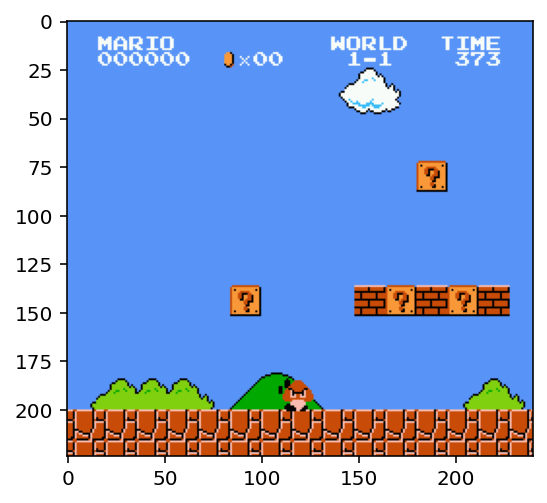

In [15]:
# %%time

import numpy as np
import random

import warnings
warnings.filterwarnings('ignore')

def generate_play(step_count, agent, return_frames=False):
    environment = Environment2()
    
    frame = environment.frame
    for _ in range(step_count or 999999999):
        if agent:
            encoding = environment.frame_encode(frame).flatten().unsqueeze(0)
            # encoding = encoding * torch.randn_like(encoding)*0.001
            action = agent.predict(encoding)[0]
        else:
            action = actions[random.randint(0, len(actions)-1)]
            action_code = actions_codes[action]
        
        frame, reward, is_done, information = environment.step(action_code, 6)

        if information['lives'] == 1:
            break
        
    environment.close()
    
    encodings, actions_all_codes = environment.blocks_identify_all()
    actions_all = [codes_actions[tuple(action_code)] for action_code in actions_all_codes]
    
    result = {
        'EncodingsUniqueCount': len(encodings.unique()),
        'FramesCount': len(encodings),
        'Encodings': encodings,
        'Actions': actions_all,
        'FrameLast': frame
    }
    
    if return_frames:
        return {**result, **{'Frames': environment.frames_all[:-1]}}
    else:
        return result

result = generate_play(1600, None, return_frames=True)
print(result['EncodingsUniqueCount'], result['FramesCount'])
plt.imshow(result['Frames'][-3]);

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

frames_all = np.array(result['Frames'])
def f(x):
    plt.imshow(frames_all[x])

interact(f, x=widgets.IntSlider(min=0, max=len(frames_all)-1, step=1, value=0));

In [ ]:
import sklearn.ensemble

classifier = sklearn.ensemble.RandomForestClassifier(n_jobs=-1)

classifier.fit(X=encodings_all,
               y=actions_all)

In [27]:
import sklearn.ensemble

classifier = sklearn.ensemble.RandomForestClassifier()

classifier.fit(X=result['Encodings'].reshape(-1, 9*15),
               y=result['Actions'])

RandomForestClassifier()

In [71]:
classifier.predict(result['Encodings'].reshape(-1, 9*15)[:3])

total 508980
drwxr-xr-x 2 root root      4096 Sep 12 04:43 blockmgr-35fddd40-119c-494f-a9b8-ba5146f779a2/
drwxr-xr-x 5 root root      4096 Sep 12 01:16 blockmgr-7a737e73-7709-4c21-9000-65231f790268/
-rw-r--r-- 1 root root    864128 Sep 12 05:00 bobs.npy
-rw-r--r-- 1 root root    864128 Sep 12 04:58 bobs.npz.npy
drwxr-xr-x 1 root root      4096 Sep 12 04:43 hsperfdata_root/
-rw-r--r-- 1 root root 258209408 Sep 12 05:03 imagez.npy
-rw-r--r-- 1 root root 258209408 Sep 12 05:04 imagz.npy
-rw-r--r-- 1 root root   2800800 Sep 12 05:10 imagz.npz
-rw-r--r-- 1 root root    203408 Sep 12 01:07 liblz4-java-10946964196109673346.so
-rw-r--r-- 1 root root         0 Sep 12 01:07 liblz4-java-10946964196109673346.so.lck
drwxr-xr-x 2 root root      4096 Sep 12 01:04 spark-1231a901-168d-4abf-bcfc-cbccd267346e/
drwx------ 4 root root      4096 Sep 12 04:43 spark-70cbc470-a29d-4708-8f0e-d58aef938fcc/
drwx------ 4 root root      4096 Sep 12 01:04 spark-9db47fb0-d7d8-4d13-a092-083b4bbb5e90/
drwxr-xr-x 2 root

In [87]:
import json

np.load('/tmp/imagz.npz')['arr_0'].shape

(1601, 224, 240, 3)

In [10]:
np.savez_compressed('/tmp/s1.npz', encodings_all)
!wc -c /tmp/s1.npz

58480 /tmp/s1.npz


In [9]:
32x100  sparksort noblocksaccumulate innerfloat 5min21s
32x100  sparksort noblocksaccumulate broadcast  3min27s
32x100  sparksort torch full convolve 18.5s
32x1000 sparksort torch full convolve 1min47s
32x800  sparksort torch full convolve 1min39s
64x800  sparksort torch full convolve 3min41s
128x800 sparksort torch full convolve 6min18s

128x800 gt3400 2min00s
256x800 top32 4min32s
256x800 top32 3min57s
256x800 top32 3min38s
256x800 top32 3min36s
256x800 self top32 4min5s
256x800 self top32 3min59s
256x800 self top32 3min58s

256x800  c5 24xlarge top32 28s
512x1000 c5 24xlarge top32 1min2s
1024xNone c5 24xlarge stats 2min42s
20_000xNone c5 24xlarge stats 45min33s

128x800 c5 4xlarge local8    1min44s
128x800 c5 4xlarge local16   1min52s
1024x1000 c5 4xlarge local8 16min41s
512x1000 c5 4xlarge local8   8min14s
512x1000 c5 4xlarge local16  8min23s
10240x1200 c54xlarge gt6200  1hr41s

SyntaxError: invalid syntax (<ipython-input-9-49b04872f75f>, line 1)

In [ ]:
%%time

import matplotlib.pyplot as plt

environments = sc.parallelize(range(32)) .map (lambda x: generate_play(None, agent=None))
# ls_frames = environments.sortByKey().collect()

ls_frames_top = environments.collect()#.top(32, key=lambda x: x[0])
# ls_frames_top = environments.filter(lambda x: x[0] > 5000)

ls_frames = ls_frames_top#.collect()
print(len(ls_frames))

fig, axs = plt.subplots(8, 4, figsize=(18, 44))
axs = axs.flatten()
fig.tight_layout()

for ax, result in zip(axs, ls_frames):
    ax.imshow(result['FrameLast'])
    ax.axis('off')
    ax.set_title((result['EncodingsUniqueCount'], result['FramesCount']))

In [ ]:
%%time
import matplotlib.pyplot as plt
environments = sc.parallelize(range(20_000)) .map (lambda x: generate_play(step_count=None, agent=None))
stats = environments .map (lambda result: (result['EncodingsUniqueCount'], result['FramesCount']))
stats_02 = stats.collect()

In [ ]:
environments = sc.parallelize(range(256)) .map (lambda x: generate_play(1600, agent=None))

ls_frames_top = []
for i in range(8):
    print(i, end='.')
    ls_frames_top.extend(environments.top(16, key=lambda x: x['EncodingsUniqueCount']))

In [ ]:
import sklearn.ensemble

classifier = sklearn.ensemble.RandomForestClassifier(n_jobs=-1)
classifier.fit(X=encodings_all, y=actions_all)

In [ ]:
result = generate_play(step_count=None, agent=classifier, return_frames=True)
print(result['EncodingsUniqueCount'], result['FramesCount'])
plt.imshow(result['Frames'][-3]);

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

frames_all = np.array(result['Frames'])
def f(x):
    plt.imshow(frames_all[x])

interact(f, x=widgets.IntSlider(min=0, max=len(frames_all)-1, step=1, value=0));

In [ ]:
# %%time

import numpy as np
import random

import warnings
warnings.filterwarnings('ignore')

def generate_play(step_count, agent, play_actions=None, return_frames=False):
    environment = Environment2()
    
    frame = environment.frame
    
    for action_1 in play_actions or range(step_count or 999999999):
        if play_actions:
            action = action_1
            
        elif agent:
            encoding = environment.frame_encode(frame).flatten().unsqueeze(0)
            # encoding = scaler.transform(encoding)
            
            # if random.random() < 0.95:
            if random.random() < (1 - action_1/1600):
                action = agent.predict(encoding)[0]
            else:
                ps = classifier.predict_proba(encoding)[0]
                action = np.random.choice(agent.classes_, p=ps)
            
        else:
            action = actions[random.randint(0, len(actions)-1)]
            
        # print(action)
        
        action_code = actions_codes[action]
        frame, reward, is_done, information = environment.step(action_code, 6)

        if information['lives'] == 1:
            break
        
    environment.close()
    
    encodings, actions_all_codes = environment.blocks_identify_all()
    actions_all = [codes_actions[tuple(action_code)] for action_code in actions_all_codes]
    
    result = {
        'EncodingsUniqueCount': len(encodings.unique()),
        'FramesCount': len(encodings),
        'Encodings': encodings,
        'Actions': actions_all,
        'FrameLast': frame
    }
    
    if return_frames:
        return {**result, **{'Frames': environment.frames_all[:-1]}}
    else:
        return result

result = generate_play(1600, None, return_frames=True)
print(result['EncodingsUniqueCount'], result['FramesCount'])
plt.imshow(result['Frames'][-3]);